In [ ]:
import os
!pip install uv

# Latests transformers + vision libraries
!uv pip install --system -q -U git+https://github.com/huggingface/transformers
!uv pip install --system -q -U timm torchvision Pillow numpy==1.*
!uv pip install pycocotools
# For training
!uv pip install --system -q -U datasets accelerate
!uv pip install --system -q -U "albumentations==1.4.6" torchmetrics
# checkpoint = "/content/rtdetr-v2-finetune/checkpoint-672"

# parmaeter : 42M


^C
Using Python 3.12.11 environment at: /venv/main
Audited 1 package in 55ms


In [14]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {device}')

Using device: cuda


In [4]:
from utils import load_models
checkpoint = "/workspace/RT_50/checkpoint-9744"
tmp = load_models(checkpoint)
image_processor = tmp['image_processor']
train_transform = tmp['train_transformer']
validation_transform = tmp['validation_transformer']
model = tmp['model']
evaluator = tmp['MAPEvaluator']

In [5]:
from data_load import loading_data , RTDataset
paths = {
    'train_json':"/workspace/data/TL_KS_BBOX",
    'train_jpg':"/workspace/data/TS_KS",
    'validation_json':'/workspace/data/VL_KS_BBOX',
    'validation_jpg':'/workspace/data/VS_KS'
}
train_data = loading_data(paths['train_json'],paths['train_jpg'])
print(train_data[0])
validation_data = loading_data(paths['validation_json'],paths['validation_jpg'])
train_RTdataset = RTDataset(train_data, image_processor, transform=train_transform)
print(train_RTdataset[0])
validation_RTdataset = RTDataset(validation_data, image_processor, transform=validation_transform)


{'image_id': 0, 'image_name': 'K3A_CHN_20161112052404_0', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7F42F7C2EDB0>, 'bboxes': [[107, 364, 86, 18], [219, 387, 76, 18]], 'category': [0, 0]}
{'pixel_values': tensor([[[[0.1647, 0.1686, 0.1686,  ..., 0.2902, 0.2863, 0.3020],
          [0.1569, 0.1647, 0.1686,  ..., 0.2980, 0.2824, 0.2863],
          [0.1569, 0.1725, 0.1765,  ..., 0.3020, 0.2824, 0.2902],
          ...,
          [0.5137, 0.5255, 0.5333,  ..., 1.0000, 1.0000, 1.0000],
          [0.5216, 0.5255, 0.5294,  ..., 1.0000, 1.0000, 1.0000],
          [0.5412, 0.5412, 0.5412,  ..., 1.0000, 1.0000, 1.0000]],

         [[0.1882, 0.1922, 0.1922,  ..., 0.2039, 0.2000, 0.2157],
          [0.1804, 0.1882, 0.1922,  ..., 0.2118, 0.1961, 0.2000],
          [0.1804, 0.1961, 0.2000,  ..., 0.2157, 0.1961, 0.2039],
          ...,
          [0.4000, 0.4118, 0.4157,  ..., 1.0000, 1.0000, 1.0000],
          [0.4078, 0.4118, 0.4118,  ..., 1.0000, 1.0000, 1.0000],
   

In [4]:
from transformers import TrainingArguments , Trainer
import torch
from data_load import collate_fn



out_dir = "/workspace/RT_50"
training_args = TrainingArguments(
    output_dir=out_dir,
    num_train_epochs=60,
    max_grad_norm=0.1,
    learning_rate=1e-4,
    warmup_steps=300,
    per_device_train_batch_size=24,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    report_to="tensorboard",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_RTdataset,
    eval_dataset=validation_RTdataset,
    processing_class=image_processor,
    data_collator=collate_fn,
    compute_metrics=evaluator,
)

trainer.train()

24
24
24
24
24


ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/venv/main/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/venv/main/lib/python3.12/site-packages/datasets/arrow_dataset.py", line 2863, in __getitems__
    batch = self.__getitem__(keys)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/root/workspace/RT_DETR/data_load.py", line 115, in __getitem__
    transformed = self.transform(image=image, bboxes=boxes, category=categories)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/venv/main/lib/python3.12/site-packages/albumentations/core/composition.py", line 228, in __call__
    p.preprocess(data)
  File "/venv/main/lib/python3.12/site-packages/albumentations/core/utils.py", line 90, in preprocess
    data[data_name] = self.check_and_convert(data[data_name], rows, cols, direction="to")
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/venv/main/lib/python3.12/site-packages/albumentations/core/utils.py", line 104, in check_and_convert
    return self.convert_to_albumentations(data, rows, cols)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/venv/main/lib/python3.12/site-packages/albumentations/core/bbox_utils.py", line 145, in convert_to_albumentations
    data = convert_bboxes_to_albumentations(data, self.params.format, rows, cols, check_validity=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/venv/main/lib/python3.12/site-packages/albumentations/core/bbox_utils.py", line 433, in convert_bboxes_to_albumentations
    return [convert_bbox_to_albumentations(bbox, source_format, rows, cols, check_validity) for bbox in bboxes]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/venv/main/lib/python3.12/site-packages/albumentations/core/bbox_utils.py", line 344, in convert_bbox_to_albumentations
    (x_min, y_min, width, height), tail = bbox[:4], bbox[4:]
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: not enough values to unpack (expected 4, got 2)


Detected chimeny with confidence 0.96 at location [129.13, 389.03, 276.28, 417.43]


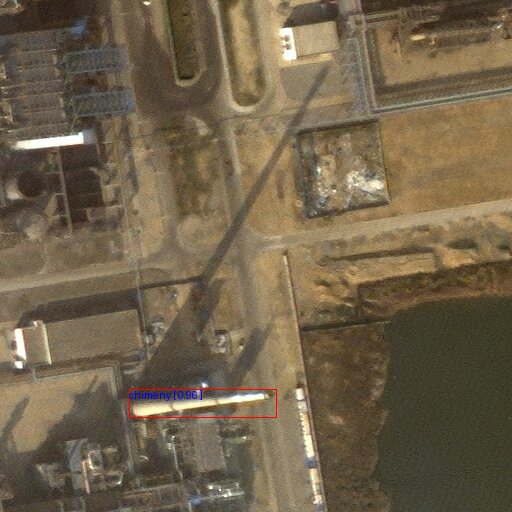

In [12]:
from transformers import AutoImageProcessor , AutoModelForObjectDetection
from PIL import Image , ImageDraw
model_repo = '/workspace/RT_50/checkpoint-9744'
image_processor = AutoImageProcessor.from_pretrained(model_repo)
model = AutoModelForObjectDetection.from_pretrained(model_repo)
image = Image.open('/workspace/data/VS_KS/K3A_CHN_20161112052404_15.jpg')
inputs = image_processor(images=[image], return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
target_sizes = torch.tensor([image.size[::-1]])

result = image_processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)[0]

for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )
image_with_boxes = image.copy()
draw = ImageDraw.Draw(image_with_boxes)

for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    text_label = model.config.id2label[label.item()]
    draw.text((x, y), f"{text_label} [ {score.item():.2f} ]", fill="blue")

image_with_boxes

In [13]:
from wbf import RTWrapper
from PIL import Image
from visualize import Draw_img_bbox
from pathlib import Path
import json
RT = RTWrapper()
a = Path('/workspace/data/VS_KS')
for path in a.rglob('*.jpg'):
    print(path)
    image = Image.open(path)
    results = RT.inference(image)[0]
    with open(Path('/workspace/data/VL_KS_BBOX')/(str(path.stem)+'.json') , 'r' , encoding= 'utf-8') as f:
        label =f.read()
    print('output',results)
    print('laebl:',label)
    # a = Draw_img_bbox(image,results)
    # a

/workspace/data/VS_KS/K3A_CHN_20180809050333_65.jpg
output {'scores': tensor([0.9610, 0.9332]), 'labels': tensor([0, 0]), 'boxes': tensor([[ 12.3446, 184.9794, 126.7581, 216.5078],
        [111.1675, 359.1030, 209.5938, 383.4641]])}
laebl: {"K3A_CHN_20180809050333_65.jpg52472":{"filename":"K3A_CHN_20180809050333_65.jpg","size":52472,"regions":[{"shape_attributes":{"name":"rect","x":12,"y":185,"width":115,"height":29},"region_attributes":{"chi_id":"1"}},{"shape_attributes":{"name":"rect","x":116,"y":359,"width":94,"height":24},"region_attributes":{"chi_id":"2"}}],"file_attributes":{"img_id":"K3A_CHN_20180809050333_65","img_height":"512","img_width":"512","img_resolution":"0.55","img_time":"18080905","img_provided":"한국항공우주연구원","provided_nm":"한국지능정보사회진흥원"}}}
/workspace/data/VS_KS/K3A_CHN_20161112052404_15.jpg
output {'scores': tensor([0.9600]), 'labels': tensor([0]), 'boxes': tensor([[129.1290, 389.0259, 276.2808, 417.4313]])}
laebl: {"K3A_CHN_20161112052404_15.jpg57643":{"filename":"K3A_

KeyboardInterrupt: 